In [1]:
### clustering with K-Means

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import numpy as np
import matplotlib.pyplot as plt
import pickle

/home/tschernn/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
## import features and charter list

# array_path = r"/home/tschernn/becore-clustering/img_array.pkl"

# with open(array_path, 'rb') as file:
#     img_array = pickle.load(file)

feature_path = r"/home/tschernn/becore-clustering/pickles/features_hog_dimred_pca.pkl"
with open(feature_path, 'rb') as file:
    image_features = pickle.load(file)

# if features are a dict, turn into array
if isinstance(image_features, dict):
    image_features = np.array(list(image_features.values()))

# charter_path = r"/home/tschernn/becore-clustering/pickles/charter_list.pkl"

# with open(charter_path, 'rb') as file:
#     charters = pickle.load(file)

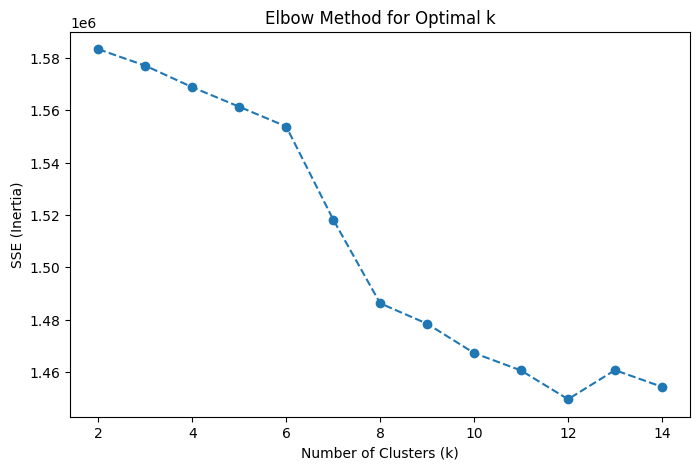

In [3]:
### find ideal number of clusters with SSE

# try different values of k
sse = []
k_values = range(2, 15)  # Check k from 2 to 14

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(image_features)
    sse.append(kmeans.inertia_)  # sum of squared distances to cluster centers

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, sse, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method for Optimal k")
plt.show()

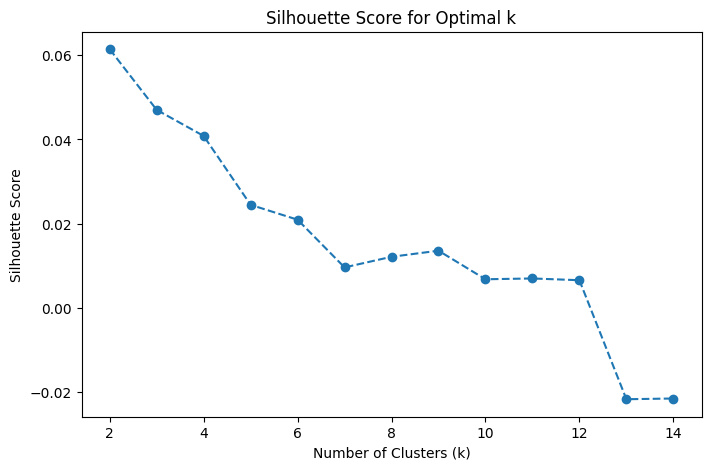

In [4]:
### find ideal number of clusters with silhouette scores

# try different k values
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(image_features)
    score = silhouette_score(image_features, labels)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal k")
plt.show()

In [5]:
# perform KMeans clustering with best silhouette score

best_k = k_values[np.argmax(silhouette_scores)]  # Pick k with highest silhouette score
print(f"Optimal number of clusters: {best_k}")

kmeans = KMeans(n_clusters = 6, random_state = 42)
labels = kmeans.fit_predict(image_features)

print("KMeans clustering complete!")

# Assign cluster labels to each image
# image_clusters = dict(zip(image_features.keys(), labels))

Optimal number of clusters: 2
KMeans clustering complete!


In [6]:
feature_path = feature_path.split('.')[0]
result_path = feature_path + '_kmeans.pkl'

# save clusters as pickle
with open(result_path, 'wb') as handle:
    pickle.dump(labels, handle, protocol=pickle.HIGHEST_PROTOCOL)